## ISF Analyze Project - Lin Peretz

## Download & Imports

In [ ]:
!pip install bertopic
!pip install python-bidi
!pip install googletrans==3.1.0a0
!pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 56.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from bertopic import BERTopic
from umap import UMAP
import matplotlib
from bidi.algorithm import get_display
from googletrans import Translator
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import os
import re
from PyPDF2 import PdfReader
from statistics import mean
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

In [ ]:
!mkdir /content/sample_data/plots

# Excel Data Analyze

In [ ]:
map_names = {"Exact sciences and Technology": "מדעים מדוייקים וטכנולוגיה",
             "Life sciences and Medicine": "מדעי החיים והרפואה",
             "Humanities": "מדעי הרוח",
             "Social Sciences": "מדעי החברה"}
colors = ['#c7ceea', '#ff9aa2', '#ffb7b2', '#ffdac1', '#e2f0cb', '#cce2cb', '#b6cfb6', '#97c1a9', '#8fcaca', '#b5ead7']

In [ ]:
# read all the xlsx data
def read_data():
    df_equipment = pd.read_excel('/content/sample_data/data/csv_files/Equipment-Grants.xlsx')
    df_post_doctoral = pd.read_excel('/content/sample_data/data/csv_files/Post-Doctoral-Grants.xlsx')
    df_research = pd.read_excel('/content/sample_data/data/csv_files/Research-Grants.xlsx')
    df_research_centers = pd.read_excel('/content/sample_data/data/csv_files/Research-Centers-Grants.xlsx')
    df_publications = pd.read_excel('/content/sample_data/data/csv_files/Publications-Grants.xlsx')
    df_workshop = pd.read_excel('/content/sample_data/data/csv_files/Workshops-Grants.xlsx')

    return df_equipment, df_post_doctoral, df_research, df_research_centers, df_publications, df_workshop

## Quantitative analysis

In [ ]:
# extract money from each df
# if $ - Multiply by 3.5
def extract_money_from_df(filed_name, df, col_name):
    temp = df[df[col_name] == filed_name]
    money = []
    if len(temp) > 0:
        for value in temp['תקציב שנתי'].values:
            if '$' in value:
                money.append(int(value.replace('$', "").replace(' ', " ")) * 3.5)
            elif '₪' in value:
                money.append(int(value.replace('₪', "").replace(' ', " ")))
        total_money = sum(money)
    else:
        return 0

    return total_money

In [ ]:
# plot pie for each field money_category
def plot_money_category_data(all_fields):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    row = 0
    col = 0
    labels = list(all_fields['Social Sciences']['Field Name'])
    for field in all_fields.keys():
        axs[row, col].pie(all_fields[field]['Total Money'], colors=colors[:6])
        axs[row, col].set_title(field)
        col = col + 1
        if col > 1:
            row = 1
            col = 0

    fig.legend(labels, loc='center right', frameon=True)
    fig.suptitle(f'Money Distribution', fontsize=20)
    plt.savefig(f'/money_distribution_pdf.png')
    plt.show()
    print()
    print()

In [ ]:
# create df with total money for each category and field
def extract_money_per_field(filed_name):
    df_equipment, df_post_doctoral, df_research, df_research_centers, df_publications, df_workshop = read_data()

    full_data = {}
    full_data['Equipment'] = extract_money_from_df(map_names[filed_name], df_equipment, 'תחום דעת')
    full_data['Post Doctoral'] = extract_money_from_df(map_names[filed_name], df_post_doctoral, 'תחום דעת')
    full_data['Research'] = extract_money_from_df(map_names[filed_name], df_research, 'תחום דעת')
    full_data['Research Centers'] = extract_money_from_df(map_names[filed_name], df_research_centers, 'תחום דעת')
    full_data['Publications'] = extract_money_from_df(map_names[filed_name], df_publications, 'תחום דעת')
    full_data['Workshop'] = extract_money_from_df(map_names[filed_name], df_workshop, 'תחום דעת')

    df = pd.DataFrame()
    df['Field Name'] = full_data.keys()
    df['Total Money'] = full_data.values()

    return df

In [ ]:
# plot money distribution per category
def money_per_category():
    all_fields = {}
    for field in map_names.keys():
        all_fields[field] = extract_money_per_field(field)

    plot_money_category_data(all_fields)

In [ ]:
# extract all data
def extract_data(list_of_df, to_analyze):
    all_institution = []
    for df in list_of_df:
        institution = list(df[to_analyze].unique())
        all_institution = all_institution + institution

    # remove duplication
    all_institution = set(all_institution)
    return all_institution

In [ ]:
# bar plot the Money/count distribution in the top 10
def plot_top_10(all_data, name, analyzed_name):
    labels = list(all_data.keys())
    fix_label = []
    for l in labels:
        fix_label.append(l[::-1])

    plt.figure(figsize=(10, 10))
    plt.bar(fix_label, all_data.values(), color=colors)
    plt.title(f'{name} distribution - Top 10 {analyzed_name}', fontsize=20)
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=0.3)
    plt.savefig(f'/content/sample_data/plots/{analyzed_name}_{name}_distribution_pdf.png')
    plt.show()
    print()
    print()

In [ ]:
# extract the count of grant
def extract_total_count(filed_name, df, col_name):
    temp = df[df[col_name] == filed_name]
    return len(temp)

In [ ]:
# analyze top researchers/institutions - money & total count per
def analyze_data(to_analyze, analyzed_name):
    all_money = {}
    all_count = {}
    df_equipment, df_post_doctoral, df_research, df_research_centers, df_publications, df_workshop = read_data()
    list_of_df = [df_equipment, df_post_doctoral, df_research, df_research_centers, df_publications, df_workshop]
    list_of_values = extract_data(list_of_df, to_analyze)

    for val in list_of_values:
        for df in list_of_df:
            if val not in all_money:
                all_money[val] = extract_money_from_df(val, df, to_analyze)
                all_count[val] = extract_total_count(val, df, to_analyze)
            else:
                all_money[val] = all_money[val] + extract_money_from_df(val, df, to_analyze)
                all_count[val] = all_count[val] + extract_total_count(val, df, to_analyze)

    print(f'#{analyzed_name} == {len(all_money)}')

    # plot money distribution
    top_10_money = dict(sorted(all_money.items(), reverse=True, key=lambda x: x[1])[:10])
    plot_top_10(top_10_money, 'Money', analyzed_name)

    # plot total count distribution
    top_10_count = dict(sorted(all_count.items(), reverse=True, key=lambda x: x[1])[:10])
    plot_top_10(top_10_count, 'Count', analyzed_name)

In [ ]:
# combine the data
def create_full_df():
    df_equipment, df_post_doctoral, df_research, df_research_centers, df_publications, df_workshop = read_data()
    full = pd.concat([df_equipment, df_post_doctoral, df_research, df_research_centers, df_publications, df_workshop])
    full = full[['תוכנית תמיכה', 'חוקר ראשי', 'כותרת המחקר', 'מוסד', 'תחום דעת', 'תקציב שנתי']]
    full.to_csv('full_data.csv')


In [ ]:
# main
def run():
    money_per_category()
    analyze_data('מוסד', 'institutions')
    analyze_data('חוקר ראשי', 'researchers')

    create_full_df()

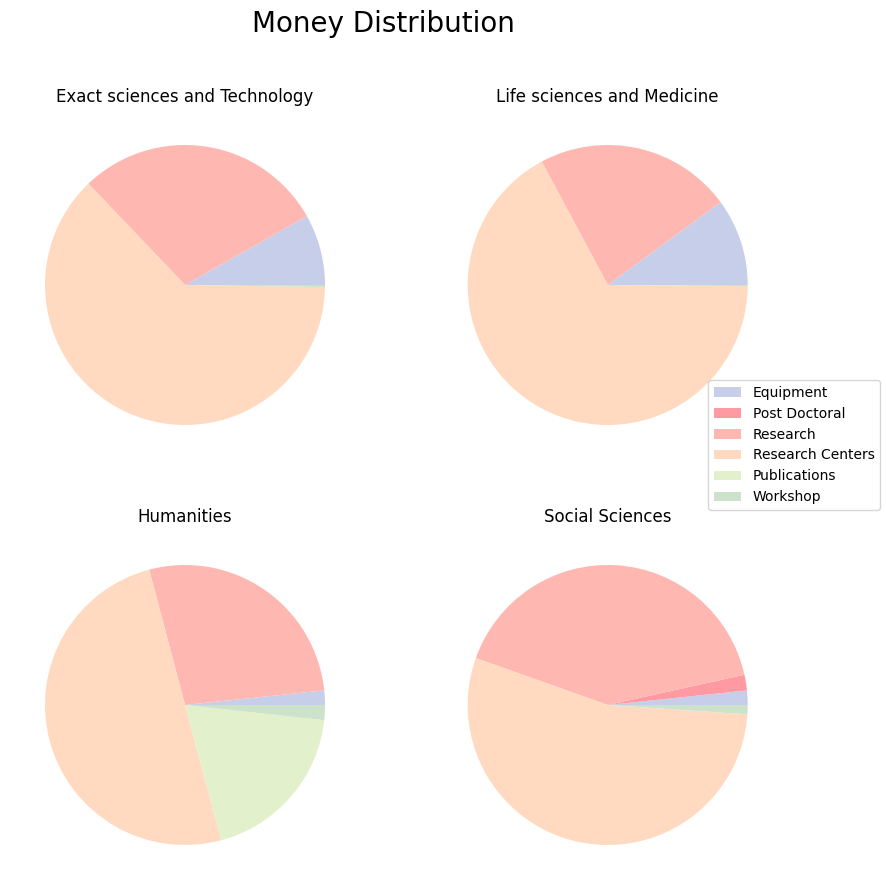



#institutions == 51


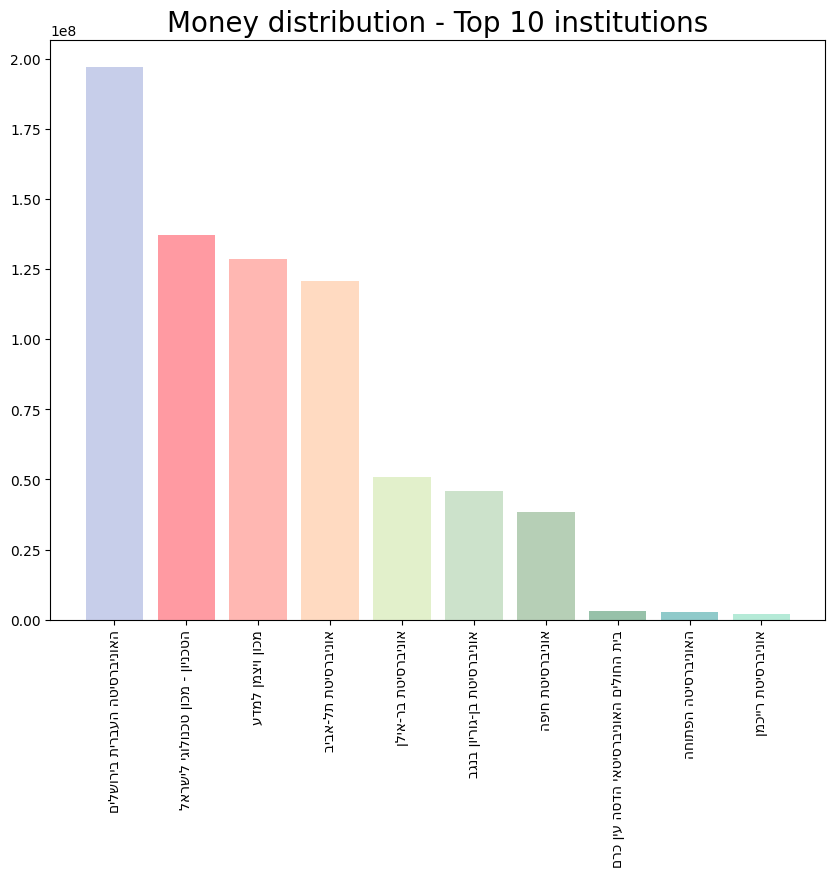

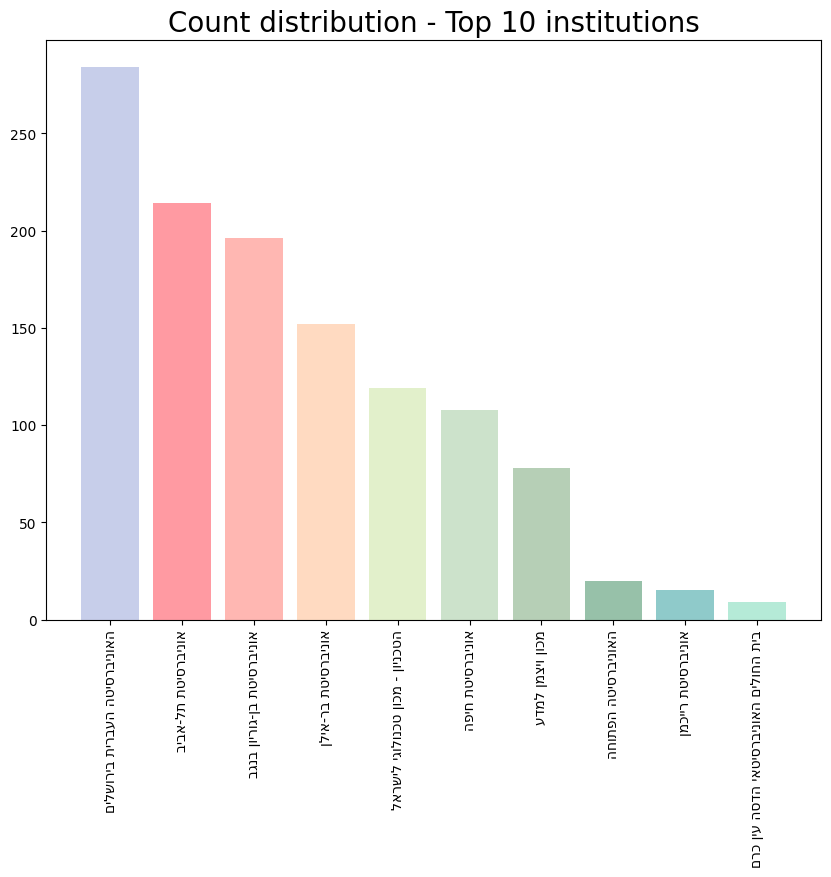



#researchers == 1013


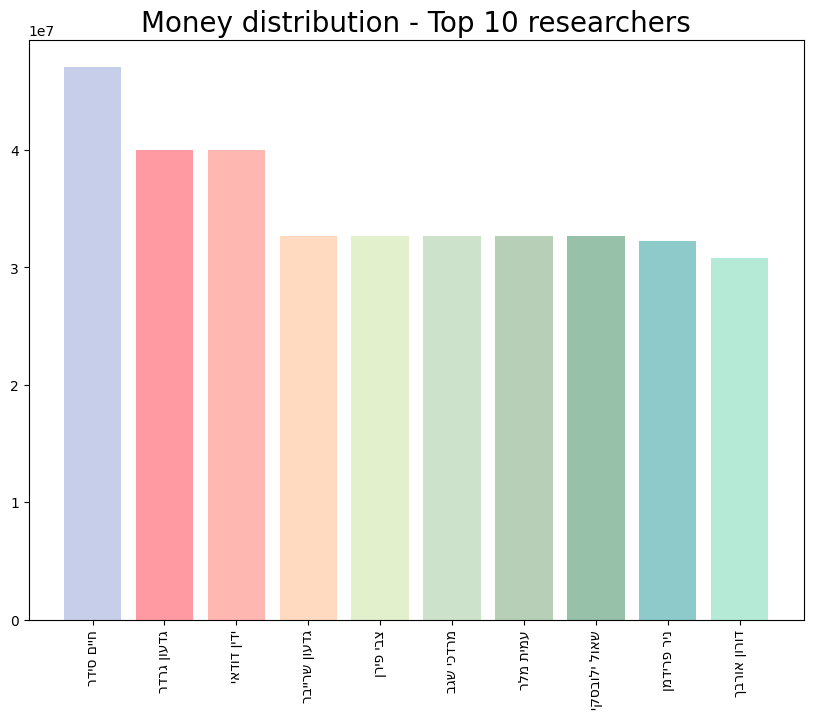

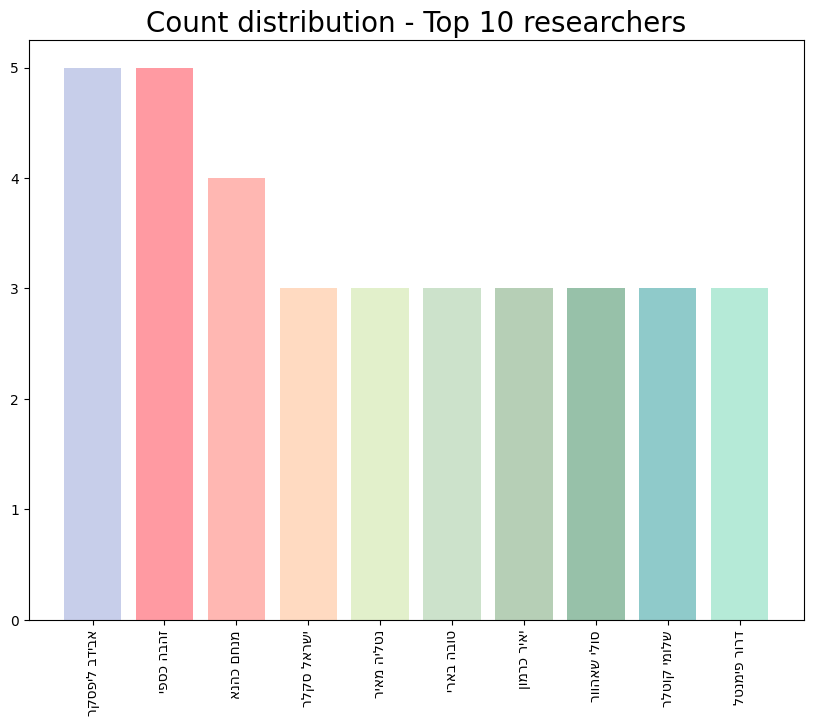

In [ ]:
run()

## Rank analysis - elsevier data isr

In [ ]:
map_top_10_institutions = {'Hebrew University of Jerusalem' : "האוניברסיטה העברית בירושלים",
                       'Technion - Israel Institute of Technology':"הטכניון - מכון טכנולוגי לישראל",
                       'Weizmann Institute of Science Israel':"מכון ויצמן למדע",
                       'Tel Aviv University':"אוניברסיטת תל-אביב",
                       "Bar Ilan's Institute for Nanotechnology and Advanced Materials":"אוניברסיטת בר-אילן",
                       "Ben-Gurion University of the Negev":"אוניברסיטת בן-גוריון בנגב",
                       'University of Haifa':"אוניברסיטת חיפה",
                       'Hadassah University Medical Centre':"בית החולים האוניברסיטאי הדסה עין כרם",
                       'Open University of Israel':"האוניברסיטה הפתוחה",
                       'IDC':"אוניברסיטת רייכמן"}
colors = ['#c7ceea', '#ff9aa2', '#ffb7b2', '#ffdac1', '#e2f0cb', '#cce2cb', '#b6cfb6', '#97c1a9', '#8fcaca', '#b5ead7']

In [ ]:
# read excel data (contain only isr data)
def read_data():
    df = pd.read_excel('/content/sample_data/data/elsevier_data_isr.xlsx')
    return df

In [ ]:
# bar plot distribution of the top 10
def plot_top_10_rank(all_data):
    labels = list(all_data.keys())
    fix_label = []
    for l in labels:
        fix_label.append(l[::-1])

    plt.figure(figsize=(10, 10))
    plt.bar(fix_label, all_data.values(), color=colors)
    plt.title(f'Rank distribution - Top 10 institutions', fontsize=20)
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=0.3)
    plt.savefig(f'/content/sample_data/plots/institutions_rank_distribution_pdf.png')
    plt.show()
    print()
    print()

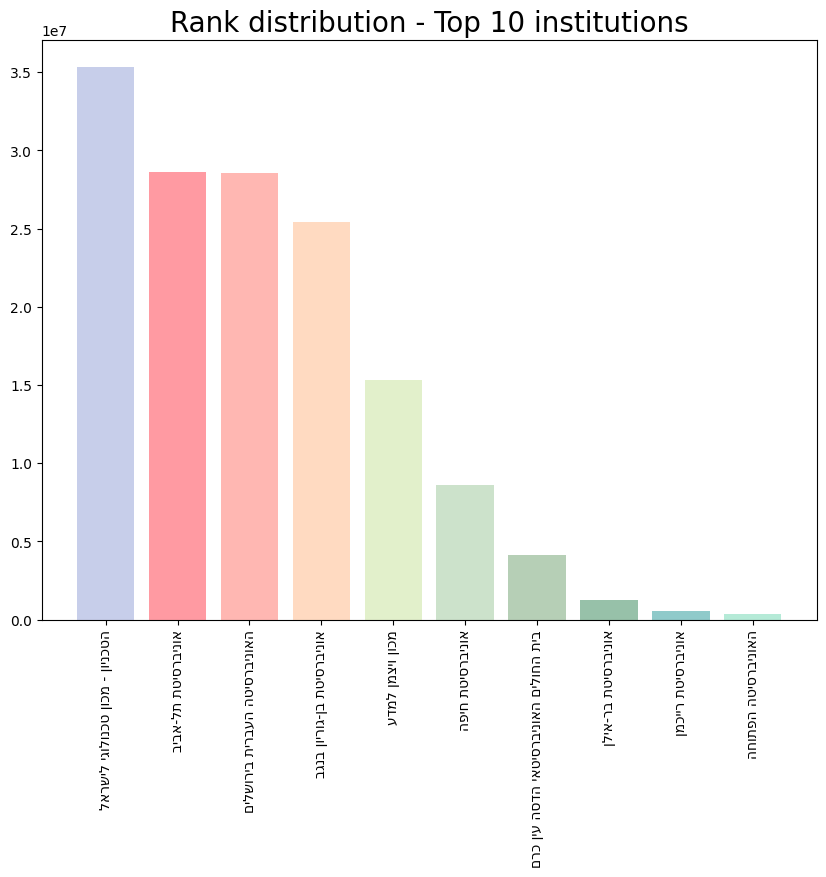

In [ ]:
def extract_rank_per_top_10_institutions():
    df = read_data()
    rank_inst = {}
    for inst in map_top_10_institutions.keys():
        temp = df[df['inst_name'] == inst]
        rank_inst[map_top_10_institutions[inst]] = temp['rank (ns)'].sum()
    rank_inst = dict(sorted(rank_inst.items(), reverse=True, key=lambda x: x[1]))
    plot_top_10_rank(rank_inst)


extract_rank_per_top_10_institutions()

## Title (Text) analysis

In [ ]:
create_full_df()
df = pd.read_csv('/content/full_data.csv')
df

,Unnamed: 0,תוכנית תמיכה,חוקר ראשי,כותרת המחקר,מוסד,תחום דעת,תקציב שנתי
0,0,מענק ציוד לחבר סגל חדש,עאיד אגבאריה,ציוד להקמת מעבדה לחקר פרוטיוסטאזיס בין אורגנילות,אוניברסיטת בן-גוריון בנגב,מדעי החיים והרפואה,587000 ₪
1,1,ציוד מדעי לחבר סגל אמצע הדרך,אמיר אהרוני,מערכת מיקרוסקופית להדמיה רבת דוגמאות,אוניברסיטת בן-גוריון בנגב,מדעי החיים והרפואה,900000 ₪
2,2,מענק ציוד לחבר סגל חדש,אורי אובולסקי,צביר מחשבים להקמת מעבדת אפידמיולוגיה חישובית,אוניברסיטת תל-אביב,מדעי החיים והרפואה,330000 ₪
3,3,מענק ציוד לחבר סגל חדש,עומרי אזנקוט,שרת למידה עמוקה עבור פיתוח מודלי סדרות זמן,אוניברסיטת בן-גוריון בנגב,מדעים מדוייקים וטכנולוגיה,333190 ₪
4,4,מענק ציוד לחבר סגל חדש,שחר אלון,ציוד להקמת מעבדה לגנומיקה מרחבית,אוניברסיטת בר-אילן,מדעי החיים והרפואה,734000 ₪
...,...,...,...,...,...,...,...
1306,33,מענק לסדנאות מחקר,יעל שדמי,מעבר למודל הסטנדרטי על קליפת המסה,הטכניון - מכון טכנולוגי לישראל,מדעים מדוייקים וטכנולוגיה,70000 ₪
1307,34,מענק לסדנאות מחקר,יוליה שיפמן,התקדמות בתכנון חלבונים: מחלבונים טיפולים לביול...,האוניברסיטה העברית בירושלים,מדעי החיים והרפואה,70000 ₪
1308,35,מענק לסדנאות מחקר,גדעון שלח-לביא,פרספקטיבות ארכיאולוגיות ואנתרופולוגיות על התגו...,האוניברסיטה העברית בירושלים,מדעי הרוח,70000 ₪
1309,36,מענק לסדנאות מחקר,מיכל שמיר,שיח הייצוג הפוליטי בראי משבר הדמוקרטיה,אוניברסיטת תל-אביב,מדעי החברה,70000 ₪


In [ ]:
# translate the text from Hebrew to English for working with bert topic
translator = Translator()
def translate_text(text):
  translated_text = translator.translate(text)
  return translated_text.text

In [ ]:
cleaned_text = list()
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
for i, r in df.iterrows():
    text = r['כותרת המחקר']
    if isinstance(text, str):
      en_text = translate_text(text)
      filtered_sentence = [w for w in en_text.split() if w.lower() not in stop_words]
      cleaned_text.append(' '.join(filtered_sentence))

df['Title_'] = cleaned_text
print(len(cleaned_text))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


1311


In [ ]:
cleaned_text[:10]

['Equipment establishment laboratory study proteostasis organelles',
 'Microscopic system multi-sample imaging',
 'cluster computers establish computational epidemiology laboratory',
 'deep learning server developing time series models',
 'Equipment establishment spatial genomics laboratory',
 'Laboratory Experimental Political Communication',
 'Equipment needed chemical analysis water synthesis characterization polymeric membranes',
 'Laboratory equipment processing analysis human tissues single cell spatial level',
 'press designed deformation rocks high temperature pressure conditions brittle yield monitoring',
 'sensor laboratory high-frequency (60-80GHz) anechoic chamber']

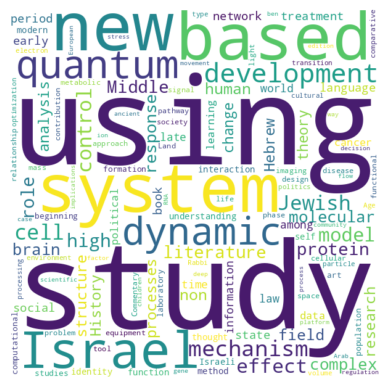

In [ ]:
def generate_word_cloud(text):
  wordcloud = WordCloud(width=600, height=600,background_color='white', max_words=200, min_font_size=10).generate(text)
  return wordcloud

wordcloud = generate_word_cloud(''.join(cleaned_text))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('word_common_.png')

In [ ]:
model = BERTopic(language="english",embedding_model='all-MiniLM-L6-v2', calculate_probabilities=True, verbose=True)
topics, probs = model.fit_transform(cleaned_text)
print(model.get_topic_freq())
print(model.get_topic_info())

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

2023-05-13 15:11:25,278 - BERTopic - Transformed documents to Embeddings
2023-05-13 15:11:33,326 - BERTopic - Reduced dimensionality
2023-05-13 15:11:33,464 - BERTopic - Clustered reduced embeddings


    Topic  Count
0      -1    517
1       0    125
2       1     92
3       2     52
4       3     48
5       4     45
6       5     37
7       6     31
8       7     31
9       8     30
10      9     27
11     10     24
12     11     21
14     12     20
13     13     20
15     14     18
16     15     16
17     16     16
18     17     15
19     18     14
20     19     14
21     20     14
22     21     13
23     22     13
24     23     12
25     24     12
26     25     12
27     26     11
28     27     11
    Topic  Count                                          Name
0      -1    517          -1_control_literature_jewish_history
1       0    125         0_theory_optimization_models_learning
2       1     92             1_hebrew_rabbi_edition_commentary
3       2     52                    2_israel_israeli_arab_land
4       3     48       3_quantum_dynamics_equilibrium_electron
5       4     45                     4_art_modern_french_early
6       5     37               5_diseases_gene_ge

In [ ]:
model.visualize_barchart(top_n_topics=10)

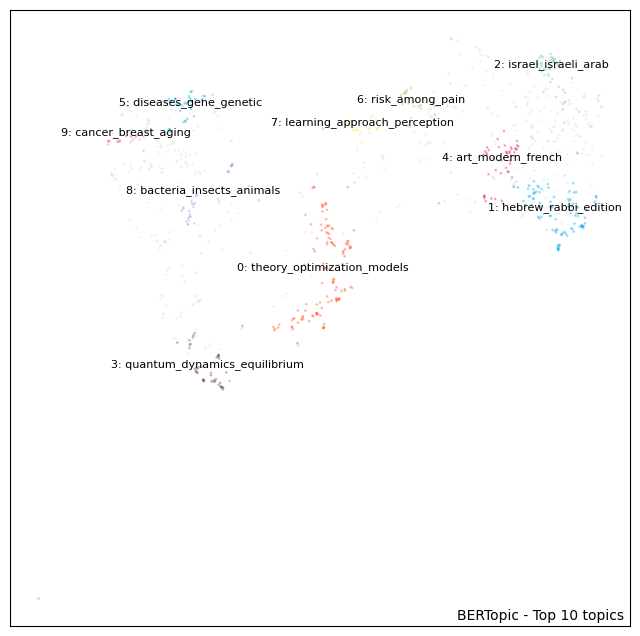

In [ ]:
def visualizing_bert_topic(model,topics,docs):


    # Prepare data for plotting
    embeddings = model._extract_embeddings(docs, method="document")
    umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings)
    df = pd.DataFrame(umap_model.embedding_, columns=["x", "y"])
    df["topic"] = topics

    # Plot parameters
    top_n = 10
    fontsize = 8

    # Slice data
    to_plot = df.copy()
    to_plot[df.topic >= top_n] = -1
    outliers = to_plot.loc[to_plot.topic == -1]
    non_outliers = to_plot.loc[to_plot.topic != -1]

    # Visualize topics
    cmap = matplotlib.colors.ListedColormap(['#FF5722', # Red
                                             '#03A9F4', # Blue
                                             '#4CAF50', # Green
                                             '#80CBC4', # FFEB3B
                                             '#673AB7', # Purple
                                             '#795548', # Brown
                                             '#E91E63', # Pink
                                             '#212121', # Black
                                             '#00BCD4', # Light Blue
                                             '#CDDC39', # Yellow/Red
                                             '#AED581', # Light Green
                                             '#FFE082', # Light Orange
                                             '#BCAAA4', # Light Brown
                                             '#B39DDB', # Light Purple
                                             '#F48FB1', # Light Pink
                                             ])

    # Visualize outliers + inliers
    fig, ax = plt.subplots(figsize=(8, 8))
    scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
    scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=1, alpha=.3, cmap=cmap)

    # Add topic names to clusters
    centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
    for row in centroids.iterrows():
        topic = int(row[1].topic)
        text = f"{topic}: " + "_".join([x[0] for x in model.get_topic(topic)[:3]])
        ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')

    ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.savefig("BERTopic_Example_Cluster_Plot.png")
    plt.show()

visualizing_bert_topic(model,topics,cleaned_text)

## Model Predict Field from title

In [ ]:
map_fileds = {"מדעים מדוייקים וטכנולוגיה" : "Exact sciences and Technology",
             "מדעי החיים והרפואה": "Life sciences and Medicine",
             "מדעי הרוח": "Humanities",
             "מדעי החברה" : "Social Sciences"}

fileds_names = []
for index,row in df.iterrows():
  if row['תחום דעת'] != ' ':
    fileds_names.append(map_fileds[row['תחום דעת']])
  else:
    fileds_names.append(" ")

df['Field_'] = fileds_names
df = df[df['Field_']!= " "]
df.head()

,Unnamed: 0,תוכנית תמיכה,חוקר ראשי,כותרת המחקר,מוסד,תחום דעת,תקציב שנתי,Title_,Field_
0,0,מענק ציוד לחבר סגל חדש,עאיד אגבאריה,ציוד להקמת מעבדה לחקר פרוטיוסטאזיס בין אורגנילות,אוניברסיטת בן-גוריון בנגב,מדעי החיים והרפואה,587000 ₪,Equipment establishment laboratory study prote...,Life sciences and Medicine
1,1,ציוד מדעי לחבר סגל אמצע הדרך,אמיר אהרוני,מערכת מיקרוסקופית להדמיה רבת דוגמאות,אוניברסיטת בן-גוריון בנגב,מדעי החיים והרפואה,900000 ₪,Microscopic system multi-sample imaging,Life sciences and Medicine
2,2,מענק ציוד לחבר סגל חדש,אורי אובולסקי,צביר מחשבים להקמת מעבדת אפידמיולוגיה חישובית,אוניברסיטת תל-אביב,מדעי החיים והרפואה,330000 ₪,cluster computers establish computational epid...,Life sciences and Medicine
3,3,מענק ציוד לחבר סגל חדש,עומרי אזנקוט,שרת למידה עמוקה עבור פיתוח מודלי סדרות זמן,אוניברסיטת בן-גוריון בנגב,מדעים מדוייקים וטכנולוגיה,333190 ₪,deep learning server developing time series mo...,Exact sciences and Technology
4,4,מענק ציוד לחבר סגל חדש,שחר אלון,ציוד להקמת מעבדה לגנומיקה מרחבית,אוניברסיטת בר-אילן,מדעי החיים והרפואה,734000 ₪,Equipment establishment spatial genomics labor...,Life sciences and Medicine


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer(max_features = 500, stop_words='english')
X = model.fit_transform(df.Title_).toarray()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
model.get_feature_names_out()[:100]

array(['1917', '1948', '19th', 'according', 'action', 'activation',
       'active', 'activity', 'acute', 'adaptive', 'adults', 'advanced',
       'africa', 'age', 'ages', 'aging', 'algorithms', 'analysis',
       'analyzing', 'ancient', 'animals', 'annotated', 'antiquity',
       'applications', 'approach', 'approaches', 'arab', 'arabic', 'art',
       'artificial', 'ashkenaz', 'aspects', 'avraham', 'babylon',
       'babylonian', 'background', 'bacteria', 'based', 'basis',
       'beginning', 'behavior', 'ben', 'beta', 'bible', 'biblical',
       'biological', 'biology', 'birth', 'black', 'bodies', 'body',
       'bone', 'book', 'books', 'brain', 'breast', 'bridging', 'cancer',
       'capital', 'carbon', 'case', 'cell', 'cells', 'cellular', 'center',
       'centuries', 'century', 'challenges', 'change', 'changes',
       'chapter', 'characterization', 'characterizing', 'chemical',
       'chemistry', 'children', 'chip', 'chiral', 'circuits', 'cities',
       'citizenship', 'city', 

In [ ]:
df_output = pd.DataFrame(data = X, columns = model.get_feature_names_out())
df_output['Field_'] = df['Field_']
df_output

,1917,1948,19th,according,action,activation,active,activity,acute,adaptive,...,west,women,work,world,writings,years,yiddish,yosef,young,Field_
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Life sciences and Medicine
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Life sciences and Medicine
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Life sciences and Medicine
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Exact sciences and Technology
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Life sciences and Medicine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Exact sciences and Technology
1304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Social Sciences
1305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Humanities
1306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Exact sciences and Technology


In [ ]:
df_output = df_output.dropna()

In [ ]:
df_output.shape

(1305, 501)

([0, 1, 2, 3],
 [Text(0, 0, 'Life sciences and Medicine'),
  Text(1, 0, 'Exact sciences and Technology'),
  Text(2, 0, 'Social Sciences'),
  Text(3, 0, 'Humanities')])

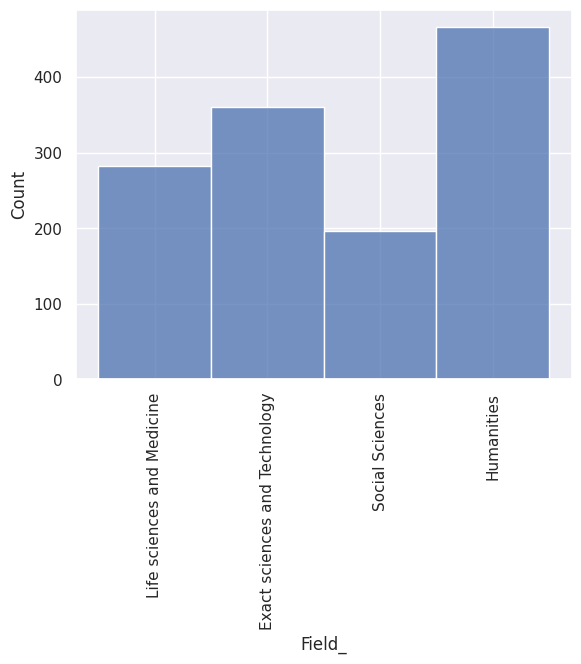

In [ ]:
import seaborn as sns
sns.set()
sns.histplot(df_output['Field_'], kde=False)
plt.xticks(rotation=90)

In [ ]:
train, test = train_test_split(df_output, test_size=0.3)
X_train, X_test = train.drop('Field_', axis=1), test.drop('Field_', axis=1)
y_train, y_test = train['Field_'], test['Field_']

In [ ]:
param_grid = {
    'n_estimators': [100,150,200],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=9, max_leaf_nodes=9, n_estimators=150)


In [ ]:
# Train model with the best param
clf = RandomForestClassifier(max_depth=9, max_leaf_nodes=9, n_estimators=150, n_jobs=-1)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print(f'Acc: {accuracy_score(y_test,y_predict)}')

Acc: 0.5229591836734694


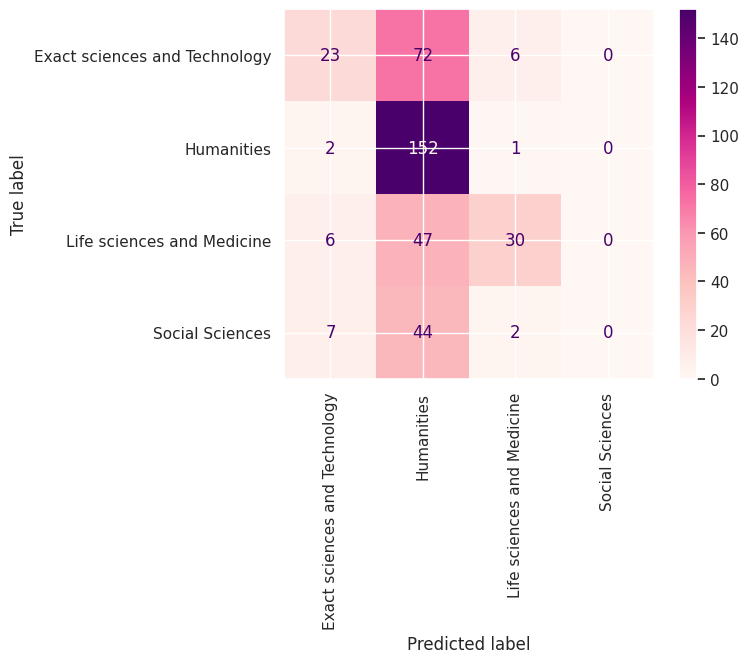

In [ ]:
cm = confusion_matrix(y_test, y_predict,labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp = disp.plot(cmap=plt.cm.RdPu,values_format='g')
plt.xticks(rotation = 90)
plt.show()

# PDF Data Analyze

In [ ]:
colors = ["#c7ceea", '#ff9aa2', '#ffb7b2', '#ffdac1']

In [ ]:
# extract the money (new project & continuous project)
def extract_money_and_total_count(money_list_to_update, total_count_list_to_update, s, name):
    if True in [char.isdigit() for char in s]:
        row = s.split(name)[0].split(" ")
        row = list(filter(lambda x: x != '', row))
        if len(row) > 1:
            money_new_p = int(row[0].replace(" ", "").replace(",", ""))
            money_continue_p = int(row[2].replace(" ", "").replace(",", ""))
            total_new_p = int(row[1].replace(" ", "").replace(",", ""))
            total_continue_p = int(row[3].replace(" ", "").replace(",", ""))
            money_list_to_update.append(money_new_p + money_continue_p)
            total_count_list_to_update.append(total_new_p + total_continue_p)

        # avoid case which one string contain 2 diff fields (like in 2013 pdf)
        for c in row:
            if c != " ":
                s = s.replace(c, "")
        s = s.replace(name, "")
        s = s.lstrip(" ")

    return money_list_to_update, total_count_list_to_update, s

In [ ]:
# extract the year from the file name
def extract_year(file_name):
    years = re.findall(r'\d+', file_name)
    year = years[0]
    if len(year) < 4:
        year = '20' + year
    return int(year)

In [ ]:
# read all pdf file, find the relevant page, and extract the relevant data from the money table
def read_pdf_files(directory):
    money_exact_sciences_and_technology = []
    money_life_sciences_and_medicine = []
    money_humanities = []
    money_social_sciences = []

    total_exact_sciences_and_technology = []
    total_life_sciences_and_medicine = []
    total_humanities = []
    total_social_sciences = []

    years = []

    for filename in os.listdir(directory):
        full_name = os.path.join(directory, filename)

        if '.pdf' in full_name:
            years.append(extract_year(full_name))
            reader = PdfReader(full_name)
            # extract text and do the search
            for page in reader.pages:
                text = page.extract_text()
                # search page with this title
                res_search = re.search('חלוקת ההקצבות למענקים', text)
                if res_search != None:
                    page_text = page.extract_text()
                    page_text = page_text.split("\n")
                    for s in page_text:
                        if 'מדעים מדויקים וטכנולוגיה' in s:
                            money_exact_sciences_and_technology, total_exact_sciences_and_technology, s = extract_money_and_total_count(
                                money_exact_sciences_and_technology, total_exact_sciences_and_technology, s,
                                'מדעים מדויקים וטכנולוגיה')

                        if 'מדעי החיים והרפואה' in s:
                            money_life_sciences_and_medicine, total_life_sciences_and_medicine, s = extract_money_and_total_count(
                                money_life_sciences_and_medicine, total_life_sciences_and_medicine, s,
                                'מדעי החיים והרפואה')
                        if 'מדעי הרוח' in s:
                            money_humanities, total_humanities, s = extract_money_and_total_count(money_humanities,
                                                                                                  total_humanities, s,
                                                                                                  'מדעי הרוח')
                        if 'מדעי החברה' in s:
                            money_social_sciences, total_social_sciences, s = extract_money_and_total_count(
                                money_social_sciences, total_social_sciences, s, 'מדעי החברה')
                    # if the title found - stop!
                    break

    return money_exact_sciences_and_technology, money_life_sciences_and_medicine, money_humanities, money_social_sciences, total_exact_sciences_and_technology, total_life_sciences_and_medicine, total_humanities, total_social_sciences, years

In [ ]:
# create dataframe from the extract data
def create_df_to_analyzed(exact_sciences_and_technology, life_sciences_and_medicine, humanities, social_sciences,
                          years, name):
    df = pd.DataFrame()
    df['years'] = years
    df['exact_sciences_and_technology'] = exact_sciences_and_technology
    df['life_sciences_and_medicine'] = life_sciences_and_medicine
    df['humanities'] = humanities
    df['social_sciences'] = social_sciences
    df = df.sort_values('years')

    full_name = f'{name}_pdf_data.csv'
    df.to_csv(full_name)

In [ ]:
# plot data, money per years for all the different fields
def plot_money_data():
    df = pd.read_csv('money_pdf_data.csv')
    df = df.sort_values('years')
    df.plot(x="years",
            y=["humanities", "social_sciences", "exact_sciences_and_technology", "life_sciences_and_medicine"],
            kind="bar", width=0.7, figsize=(20, 10), color=colors)
    plt.title('Grants money per years')
    plt.legend(["Humanities", "Social Sciences", "Exact sciences & Technology", "Life sciences & Medicine"])
    plt.savefig('/content/sample_data/plots/bar_money_pdf.png')
    plt.show()
    print()
    print()

In [ ]:
# plot data, total count per years for all the different fields
def plot_total_count_data():
    df = pd.read_csv('total_count_pdf_data.csv')
    df.plot(x="years",
            y=["humanities", "social_sciences", "exact_sciences_and_technology", "life_sciences_and_medicine"],
            kind="bar", width=0.7, figsize=(20, 10), color=colors)
    plt.title('Count grants per years')
    plt.legend(["Humanities", "Social Sciences", "Exact sciences & Technology", "Life sciences & Medicine"])
    plt.savefig('/content/sample_data/plots/bar_total_count_pdf.png')
    plt.show()
    print()
    print()

In [ ]:
def print_avg_money_data(new_df):
    for col in new_df.columns:
        if col != "years":
            avg = int(mean(new_df[col]))
            print(f'The average money per grants over the years (2012-2022) in the field {col} is {avg}')

In [ ]:
# plot money divided by total count & print avg money per filed
def plot_money_divided_by_quantity_data():
    money = pd.read_csv('money_pdf_data.csv')
    total_count = pd.read_csv('total_count_pdf_data.csv')

    new_df = pd.DataFrame()
    new_df['years'] = money['years']
    new_df['exact_sciences_and_technology'] = money['exact_sciences_and_technology'] / total_count[
        'exact_sciences_and_technology']
    new_df['life_sciences_and_medicine'] = money['life_sciences_and_medicine'] / total_count[
        'life_sciences_and_medicine']
    new_df['humanities'] = money['humanities'] / total_count['humanities']
    new_df['social_sciences'] = money['social_sciences'] / total_count['social_sciences']

    new_df.plot(x="years",
                y=["humanities", "social_sciences", "exact_sciences_and_technology", "life_sciences_and_medicine"],
                kind="bar", width=0.7, figsize=(20, 10), color=colors)
    plt.title('Grants money per total counts')
    plt.legend(["Humanities", "Social Sciences", "Exact sciences & Technology", "Life sciences & Medicine"])
    plt.savefig('/content/sample_data/plots/bar_total_count_per_money_pdf.png')
    plt.show()
    print()

    print_avg_money_data(new_df)

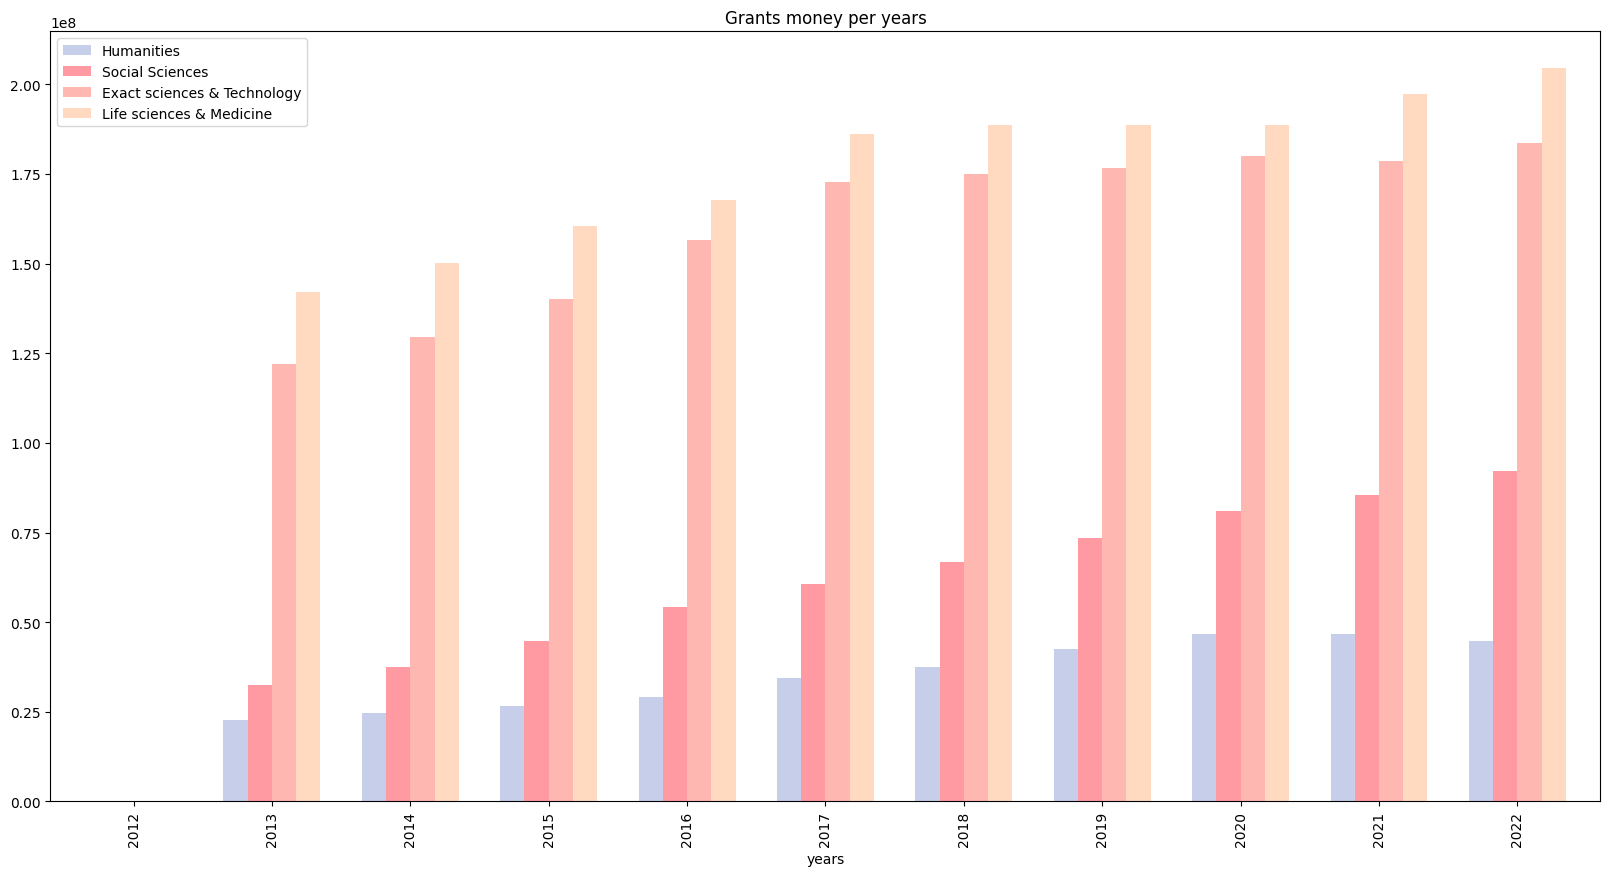

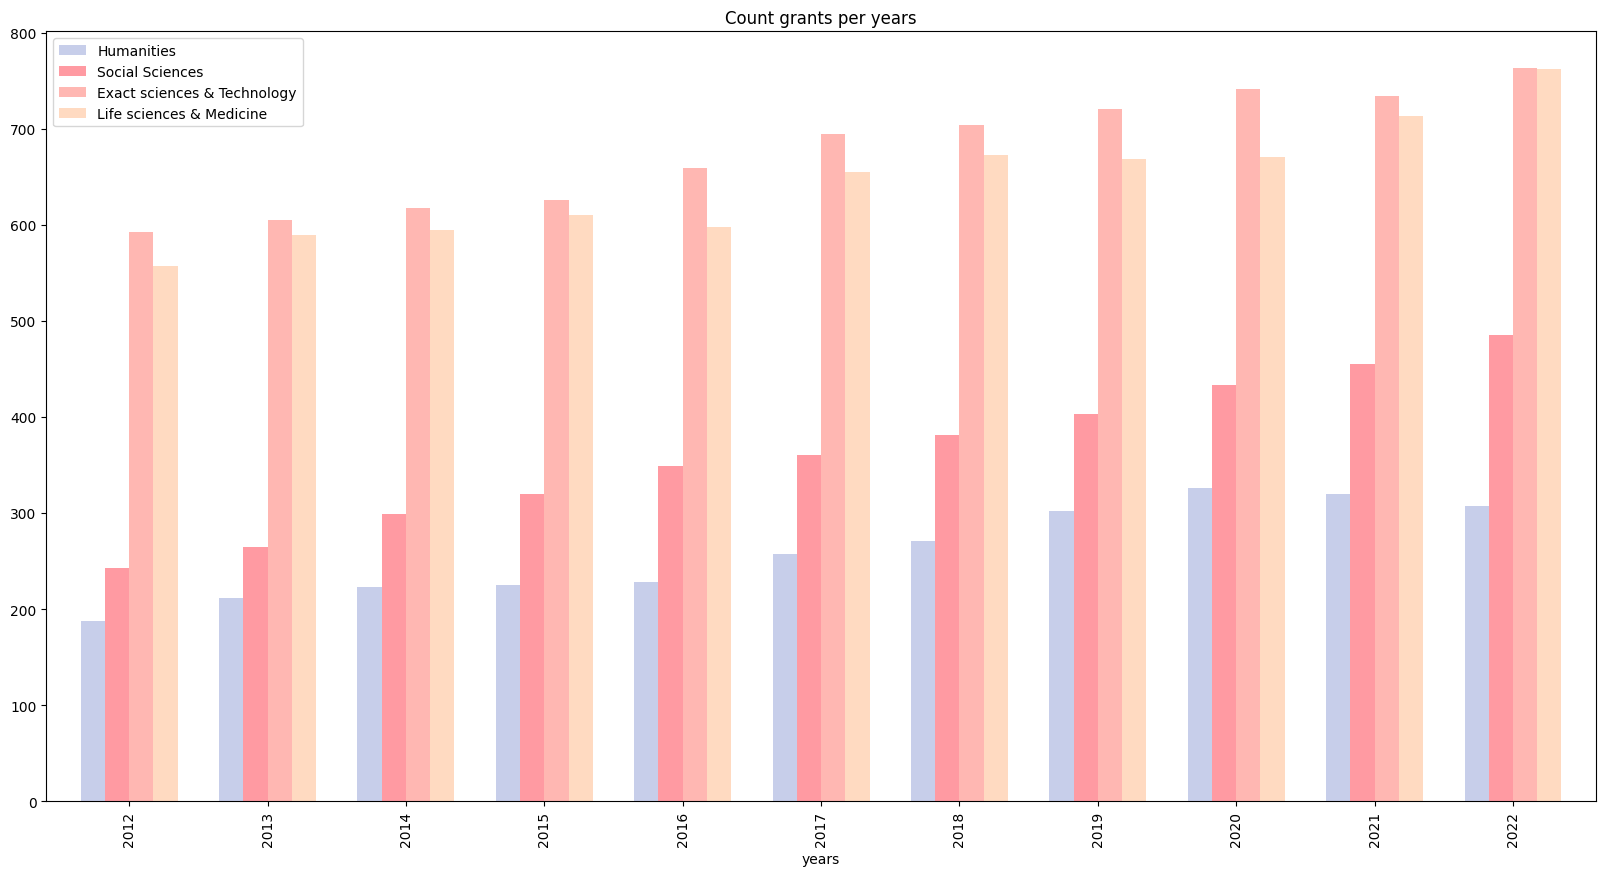

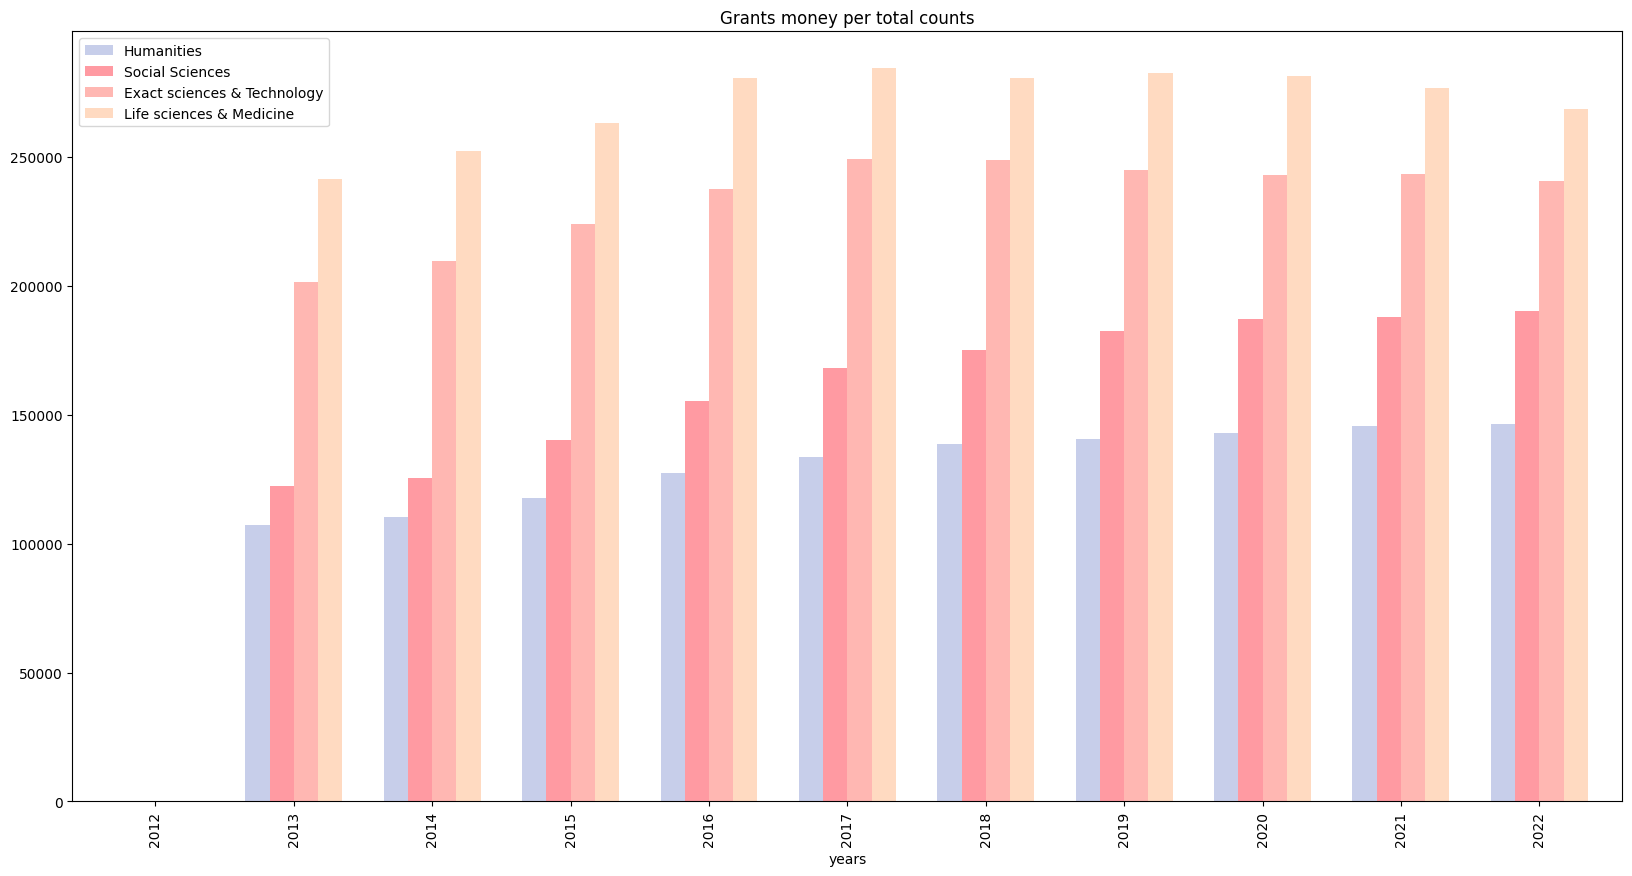


The average money per grants over the years (2012-2022) in the field exact_sciences_and_technology is 212940
The average money per grants over the years (2012-2022) in the field life_sciences_and_medicine is 246434
The average money per grants over the years (2012-2022) in the field humanities is 119082
The average money per grants over the years (2012-2022) in the field social_sciences is 148533


In [ ]:
# main
def run():
    money_exact_sciences_and_technology, money_life_sciences_and_medicine, money_humanities, money_social_sciences, total_exact_sciences_and_technology, total_life_sciences_and_medicine, total_humanities, total_social_sciences, years = read_pdf_files(
        "/content/sample_data/data/pdf_files/")
    create_df_to_analyzed(money_exact_sciences_and_technology, money_life_sciences_and_medicine, money_humanities,
                          money_social_sciences, years, "money")
    create_df_to_analyzed(total_exact_sciences_and_technology, total_life_sciences_and_medicine, total_humanities,
                          total_social_sciences, years, "total_count")

    plot_money_data()
    plot_total_count_data()
    plot_money_divided_by_quantity_data()

run()